### Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

### Text preparator class

In [3]:
import nltk
import re
import pymorphy2
from nltk.corpus import stopwords
from typing import List
nltk.download('stopwords')

class TextPreparator(object):
    def __init__(self):
        self.stop_words = set(stopwords.words('russian'))
        self.stop_words.add('лишь')
        self.stop_words.add('здравствуйте')
        self.stop_words.add('уважаемый')

        self.morph = pymorphy2.MorphAnalyzer()
    
    def __lower(self, text: str) -> str:
        '''Function convert text to lower case'''
        return text.lower()
    
    def __get_lemmas(self, words: List[str]) -> List[str]:
        '''Function do lemmatize for every word in input list'''
        return [self.morph.parse(word)[0].normal_form for word in words]
            
    def __remove_stopwords(self, words: List[str]) -> List[str]:
        '''
        Function remove stop words from a list of words
            Args:
                words (List[str]): List of words
            Returns:
                List of words
        '''
        return [word for word in words if word not in self.stop_words]
    
    def __filter_words_by_length(self, words: List[str], length: int) -> List[str]:
        '''
        Function filter words by length greater then lenght param
            Args:
                words (List[str]): List of words
                
                length (int): Needed length to filter
            Returns:
                List of words greater then length param
        '''
        return [word for word in words if len(word) > length]
    
    def prepare_text(self, text: str) -> str:
        text = self.__lower(text)
        words = re.findall(r'[а-яА-Я]+', text)
        words = self.__remove_stopwords(words)
        words = self.__get_lemmas(words)
        words = self.__filter_words_by_length(words, 2)

        return ' '.join(words)
    
    def __call__(self, text: str) -> str:
        return self.prepare_text(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SsaWin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenizer class

In [4]:
from spacy.lang.ru import Russian

class Tokenizer(object):
    def __init__(self):
        self.nlp = Russian()

    def tokenize(self, text: str) -> List[str]:
        return [token.text for token in self.nlp(text)]
    
    def __call__(self, text: str) -> List[str]:
        return self.tokenize(text)

### Prepare and tokenize text

In [651]:
def prepare_tokenize_text(text: str, tokenizer: Tokenizer, preparator: TextPreparator) -> List[str]:
    return tokenizer(preparator(text))

### Dataset class

In [652]:
class QADataset(Dataset):
    def __init__(self, dataframe, doc2vec_model, tokenizer, preparator):
        self.dataframe = dataframe
        self.model = doc2vec_model
        
        self.tokenizer = tokenizer
        self.preparator = preparator

        self.tokenized_data = self.tokenize_data()

    def tokenize_data(self):
        tokenized_data = []
        for idx, row in self.dataframe.iterrows():
            question_tokens = self.tokenizer(self.preparator(row['question']))
            answer_tokens = self.tokenizer(self.preparator(row['answer']))

            question_embedding = self.model.infer_vector(question_tokens)
            answer_embedding = self.model.infer_vector(answer_tokens)

            tokenized_data.append((question_embedding, answer_embedding, row['target']))

        return tokenized_data

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        question_embedding, answer_embedding, target = self.tokenized_data[idx]

        question_embedding = torch.tensor(question_embedding)
        answer_embedding = torch.tensor(answer_embedding)
        target = torch.tensor(target, dtype=torch.float32)

        return question_embedding, answer_embedding, target

### Model class

In [6]:
class QAClassifierModel(nn.Module):
    def __init__(self, input_size):
        super(QAClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_size * 2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2, dim=1):
        x = torch.cat([x1, x2], dim=dim)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

### QACLassifier class

In [654]:
class QAClassifier:
    def __init__(self, model, train_dataset, val_dataset, test_dataset, batch_size=32, lr=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size
        self.lr = lr
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loss_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []

    def train(self, epochs=10):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0

            for batch in train_loader:
                x1, x2, target = batch
                x1, x2, target = x1.to(self.device), x2.to(self.device), target.to(self.device)
                
                self.optimizer.zero_grad()
                
                output = self.model(x1, x2)
                
                loss = self.criterion(output.squeeze(), target)
                loss.backward()

                self.optimizer.step()

                running_loss += loss.item()

            average_train_loss = running_loss / len(train_loader)
            self.train_loss_history.append(average_train_loss)

            val_loss, val_accuracy = self.validate()
            self.val_loss_history.append(val_loss)
            self.val_accuracy_history.append(val_accuracy)

        self.plot_metrics()

    def validate(self):
        self.model.eval()
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        all_predictions, all_targets = [], []

        with torch.no_grad():
            val_loss = 0.0
            correct = 0
            total = 0
            
            for batch in val_loader:
                x1, x2, target = batch
                x1, x2, target = x1.to(self.device), x2.to(self.device), target.to(self.device)

                output = self.model(x1, x2)

                loss = self.criterion(output.squeeze(), target)
                val_loss += loss.item()

                predicted = torch.round(output.squeeze()).cpu().numpy()
                all_predictions.extend(predicted)
                all_targets.extend(target.cpu().numpy())

                total += target.size(0)
                correct += (predicted == target.cpu().numpy()).sum()

            accuracy = correct / total
            average_val_loss = val_loss / len(val_loader)

        return average_val_loss, accuracy

    def test(self):
        self.model.eval()
        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        all_predictions, all_targets = [], []

        with torch.no_grad():
            for batch in test_loader:
                x1, x2, target = batch
                x1, x2, target = x1.to(self.device), x2.to(self.device), target.to(self.device)
                output = self.model(x1, x2)
                predicted = torch.round(output.squeeze()).cpu().numpy()
                all_predictions.extend(predicted)
                all_targets.extend(target.cpu().numpy())

        accuracy = accuracy_score(all_targets, all_predictions)
        print(f"Test Accuracy: {accuracy:.4f}")
    
    def plot_metrics(self):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(self.train_loss_history, label='Train Loss')
            plt.plot(self.val_loss_history, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(self.val_accuracy_history, label='Validation Accuracy', color='green')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()


    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

### Data loading

In [655]:
data = pd.read_csv('./data/dataset.csv')

### Define text preparator and tokenizer

In [656]:
tokenizer = Tokenizer()
text_preparator = TextPreparator()

### Doc2Vec model training

In [707]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_data = [TaggedDocument(words=prepare_tokenize_text(row['question'] + ' ' + row['answer'], tokenizer, text_preparator), tags=[str(row.name)])
               for _, row in data.iterrows()]

doc2vec_model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=10)

doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

doc2vec_model.save('./data/models/doc2vec')

### Train test splitting

In [658]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

### Load doc2vec model

In [659]:
from gensim.models import Doc2Vec
doc2vec_model = Doc2Vec.load('./data/models/doc2vec')

### Define datasets

In [660]:
train_dataset = QADataset(train_data, doc2vec_model, tokenizer, text_preparator)
test_dataset = QADataset(test_data, doc2vec_model, tokenizer, text_preparator)
val_dataset = QADataset(val_data, doc2vec_model, tokenizer, text_preparator)

### Model initialization

In [661]:
input_size = 300
batch_size = 64

model = QAClassifierModel(input_size)

### Start training

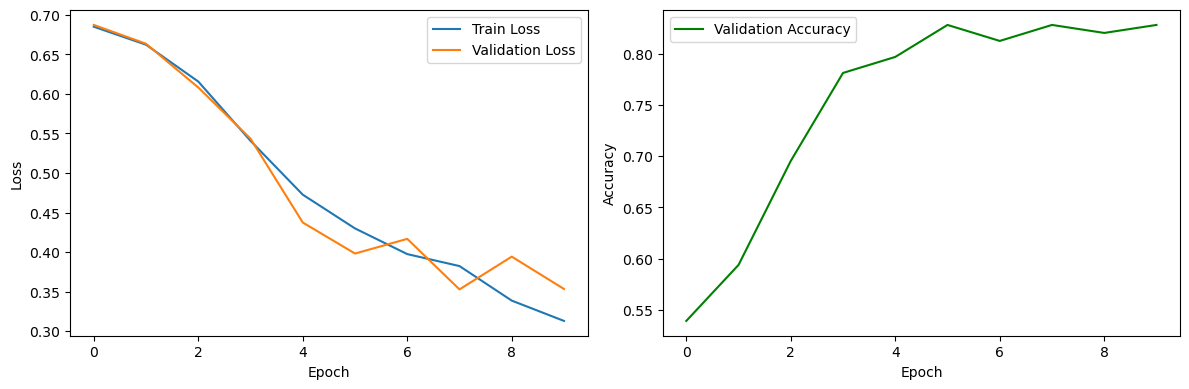

In [662]:
classifier = QAClassifier(model, train_dataset, val_dataset, test_dataset, batch_size, lr=5e-3)
classifier.train(epochs=10)

### Evaluate

In [704]:
classifier.test()

Test Accuracy: 0.7500


In [706]:
classifier.save_model('./data/models/classifier')

Model saved to ./data/models/classifier


In [7]:
import torch
from gensim.models import Doc2Vec

class QAPredictor:
    def __init__(self, model_path: str, doc2vec_model_path: str, input_size: int, tokenizer: Tokenizer, preparator: TextPreparator):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = QAClassifierModel(input_size).to(self.device)
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

        self.doc2vec_model: Doc2Vec = Doc2Vec.load(doc2vec_model_path)
        self.tokenizer = tokenizer
        self.preparator = preparator

    def predict(self, question, answer):
        question_tokens = self.tokenizer(self.preparator(question))
        answer_tokens = self.tokenizer(self.preparator(answer))

        question_embedding = self.doc2vec_model.infer_vector(question_tokens)
        answer_embedding = self.doc2vec_model.infer_vector(answer_tokens)

        with torch.no_grad():
            question_tensor = torch.tensor(question_embedding, dtype=torch.float32).to(self.device)
            answer_tensor = torch.tensor(answer_embedding, dtype=torch.float32).to(self.device)
            output = self.model(question_tensor, answer_tensor, dim=0)

            prediction = output.squeeze().item()

        return prediction

model_path = './data/models/classifier'  
doc2vec_model_path = './data/models/doc2vec'
input_size = 300
tokenizer = Tokenizer()
text_preparator = TextPreparator()
predictor = QAPredictor(model_path, doc2vec_model_path, input_size, tokenizer, text_preparator)

question_text = "Кратко опишите алгоритм классификации методом ближайших соседей (подаваемый на классификацию вектор назовите пробным вектором)"
answer_text = """Ну по поводу алгоритма, он красивый, строится на основе n соседей, расстояние междy находится векторами, что еще сказать"""

prediction = predictor.predict(question_text, answer_text)
print(f"Prediction: {prediction}")


Prediction: 0.40019461512565613
